In [19]:
import torch
from utility import My_Dataset
from utility import mean_and_std,get_params_and_gradients_norm,train_model
from utility import validation, early_stopping
from utility import Augmented_Dataset 
from utility import data_augmentation
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset #
from torch.utils.data import DataLoader,ConcatDataset
import torchvision.datasets as datasets 
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter 
import numpy as np #
from skimage import io #
from matplotlib import pyplot as plt

In [20]:
import os 
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd 
from collections import deque 

In [21]:
ARCH = [8,'M',16,'M',32,0]   #architecture of the base network 


In [22]:
class BASE_CNN(nn.Module): 
    def __init__(self,in_channels = 1, num_classes = 15,architecture=ARCH,batch_norm=False): 
        super(BASE_CNN,self).__init__()
        self.in_channels = in_channels 
    
        self.batch_norm = batch_norm
        self.conv_layers = self.create_conv_layers(architecture)
        self.fcs = nn.Sequential(nn.Linear(32*12*12,num_classes))
        
        #self.batch_norm = batch_norm
    def create_conv_layers(self, architecture): 
        layers = [] 
        in_channels = self.in_channels 
        for x in architecture: 
            if(type(x)==int and x!=0): 
                out_channels = x 
                
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=(3,3),
                           stride =1, padding = (0,0))]
                in_channels = x
                if (self.batch_norm==True):
                    layers+=[nn.BatchNorm2d(out_channels)]
                layers += [nn.ReLU()]
                    
            elif x =='M': 
                layers +=[nn.MaxPool2d(kernel_size= (2,2),stride = (2,2))]
        return nn.Sequential(*layers)
    def initialize_weight(self): 
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): 
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias,0)
    def forward(self,x): 
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fcs(x)
        return x

In [23]:
mean, std = mean_and_std()

In [24]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize([mean], [std]),
])


In [25]:
learning_rate = 0.01
batch_size = 32 

In [26]:
dataset = My_Dataset(root = "train", transform = transforms)
train_number = int(len(dataset)*0.85)
val_number = len(dataset)-train_number
train_set, val_set = torch.utils.data.random_split(dataset,[train_number,val_number])
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle=True )
val_loader = DataLoader(dataset = val_set, batch_size=64, shuffle=False )

In [27]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
device

device(type='cuda')

In [29]:
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 

In [30]:
print(model)

BASE_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (fcs): Sequential(
    (0): Linear(in_features=4608, out_features=15, bias=True)
  )
)


In [31]:
data, targets = next(iter(train_loader))

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [33]:
def overfit_single_batch(data, targets, model, criterion, writer,num_epochs=3001):
    model.train() 
    loss = 0
    step = 0 
    epoch=0
    data = data.to(device)
    targets = targets.to(device)
    for epoch in range(num_epochs): 
        step+=1
        if ((epoch)%100)==0: 
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            writer.add_histogram('conv_1',model.conv_layers[0].weight, epoch)
            writer.add_histogram('bias_1',model.conv_layers[0].bias, epoch)
            writer.add_histogram('conv_2',model.conv_layers[3].weight,epoch)
            writer.add_histogram('bias_2',model.conv_layers[3].bias,epoch)
            writer.add_histogram('conv_3',model.conv_layers[6].weight,epoch)
            writer.add_histogram('bias_3',model.conv_layers[6].bias,epoch)
            writer.add_histogram('fcs',model.fcs[0].weight,epoch)
            writer.add_histogram('fcs_bias',model.fcs[0].bias,epoch)
            print(loss)
        
        scores = model(data)
        loss = criterion(scores, targets)
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        _, pred = scores.max(1) 
        num_correct = (pred==targets).sum() 
        running_train_acc = float(num_correct)/(float(data.shape[0]))
        writer.add_scalar('Training Loss',loss,global_step = step)
        writer.add_scalar('Training_accuracy',running_train_acc,global_step=step)
        #params_norm, gradients_norm = get_params_and_gradients_norm(model.named_parameters())
        #trajectory["parameters"].append(params_norm)
        #trajectory["gradients"].append(gradients_norm)
        

In [34]:
writer_2 = SummaryWriter(f'runs/MODEL_1Adam')

In [35]:
overfit_single_batch(data,targets,model,criterion,writer_2)

Epoch [1/3001]
0
Epoch [101/3001]
tensor(2.7319e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [201/3001]
tensor(1.1268e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [301/3001]
tensor(2.0750e-06, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [401/3001]
tensor(8.7916e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [501/3001]
tensor(6.2584e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [601/3001]
tensor(4.7311e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [701/3001]
tensor(3.7625e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [801/3001]
tensor(3.0175e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [901/3001]
tensor(2.4959e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [1001/3001]
tensor(2.1234e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [1101/3001]
tensor(1.8254e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [1201/3001]
tensor(1.5646e-07, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch [1

In [44]:
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(),lr=0.001)

learning_rate = 0.001 
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [45]:
PATH = "adamOptimizeer_model.py"

In [46]:
writer_3= SummaryWriter(f'runs/MODEL_Adam_train')

In [47]:
ep =early_stopping(PATH,5,model,train_loader,val_loader, criterion, optimizer,writer_3,80,patience=15,device=device)

In [48]:
ep

27

In [49]:
new_model = BASE_CNN(1,15) 
check = torch.load(PATH)
new_model.load_state_dict(check['parameters'])


<All keys matched successfully>

In [50]:
_ = new_model.eval()

In [51]:
a,_ = validation(new_model,val_loader,nn.CrossEntropyLoss())
print(a)

43.55555555555555


In [52]:
test_dataset = My_Dataset(root = "test", transform = transforms)
test_loader = DataLoader(dataset = test_dataset, batch_size=64, shuffle=False)


In [53]:
test_accuracy,test_loss =validation(new_model,test_loader,nn.CrossEntropyLoss())

In [54]:
test_accuracy

38.55946398659966

In [8]:
#Augmented data det 

In [17]:
#I crop all the image in the train dataset 
#with the parameter train = True only the data intended for the training will be modified 


In [55]:
train_dataset1 = Augmented_Dataset(root="train",transform=transforms,augmentation=data_augmentation,flip=False,crop=True,train=True)

In [56]:
#dataset without modifications 
train_dataset2 = Augmented_Dataset(root="train",transform=transforms,train=True)

In [57]:
#here I flip all the images 
train_dataset3 = Augmented_Dataset(root="train",transform=transforms,augmentation=data_augmentation,flip=True,crop=False,train=True)

In [58]:
#here first I flip and then I crip all the images 
train_dataset4 = Augmented_Dataset(root="train",transform=transforms,augmentation=data_augmentation,flip=True,crop=True,train=True)

In [59]:
augmented_dataset = ConcatDataset([train_dataset1,train_dataset2,train_dataset3,train_dataset4])

In [60]:
val_dataset = Augmented_Dataset(root="train",transform=transforms,val=True)

In [61]:
augmented_train_loader = DataLoader(dataset = augmented_dataset, batch_size=32, shuffle=True )
val_loader = DataLoader(dataset = val_dataset, batch_size= 64, shuffle=False )

In [62]:
learning_rate = 0.001
model = BASE_CNN(1,15).to(device)
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [63]:
PATH_MODEL_AUGMENTATION= "model_augmentation.py"
writer_4 = SummaryWriter(f'runs/MODEL_WITH_AUGMENTATION')

In [64]:
ep =early_stopping(PATH_MODEL_AUGMENTATION,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_4,80,patience=15,device=device)

In [65]:
new_model = BASE_CNN(1,15) #I validate in the cpu 
check_model = torch.load(PATH_MODEL_AUGMENTATION)
new_model.load_state_dict(check_model['parameters'])

<All keys matched successfully>

In [46]:
_ = new_model.eval()
augmented_model_accuracy,augmented_model_loss = validation(new_model,val_loader,nn.CrossEntropyLoss())

In [47]:
augmented_model_accuracy

50.66666666666667

In [48]:
#no modification is done on the test data and it is all used 
test_data = Augmented_Dataset(root = "test", transform = transforms)

In [49]:
test_loader = DataLoader(dataset = test_data, batch_size=len(test_data), shuffle=False )

In [50]:
test_accuracy_aug_model,_ = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [52]:
test_accuracy_aug_model

47.93969849246231

In [54]:
model = BASE_CNN(1, 15,batch_norm=True).to(device)
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

In [57]:
PATH_NORM = "model_batch_norrm.py"
writer_5 = SummaryWriter(f'runs/MODEL_WITH_BATCH_NORM')

In [58]:
ep =early_stopping(PATH_NORM,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_5,80,patience=15,device=device)

In [60]:
new_model = BASE_CNN(1,15,batch_norm=True) #I validate in the cpu 
check_model_2 = torch.load(PATH_NORM)
new_model.load_state_dict(check_model_2['parameters'])

<All keys matched successfully>

In [61]:
_ = new_model.eval()
accuracy_batch,loss = validation(new_model,val_loader,nn.CrossEntropyLoss())

In [62]:
accuracy_batch

57.77777777777777

In [63]:
test_accuracy_batch_model,_ = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [65]:
test_accuracy_batch_model

57.45393634840871

In [ ]:
ARCH = [16,'M',32,'M',64,0]
from collections import deque 
#Now I try to change the size of the filters and to add more channels in the  convolutional layers 
#I also add padding of one 

In [ ]:
class CNN_2(nn.Module): 
    def __init__(self,in_channels = 1, num_classes = 15,architecture=ARCH,batch_norm=False): 
        super(CNN_2,self).__init__()
        self.in_channels = in_channels 
        self.batch_norm = batch_norm
        self.conv_layers = self.create_conv_layers(architecture)
        self.fcs = nn.Sequential(nn.Linear(32*11*11,num_classes))
        #self.batch_norm = batch_norm
    def create_conv_layers(self, architecture): 
        kernel_size = deque([7,5,3])
        
        layers = [] 
        in_channels = self.in_channels 
        for x in architecture: 
            if(type(x)==int and x!=0): 
                out_channels = x 
                k=kernel_size.pop()
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=(k,k),
                           stride =1, padding = (1,1))]
                in_channels = x
                if (self.batch_norm==True):
                    layers+=[nn.BatchNorm2d(out_channels)]
                layers += [nn.ReLU()]
                    
            elif x =='M': 
                layers +=[nn.MaxPool2d(kernel_size= (2,2),stride = (2,2))]
        return nn.Sequential(*layers)
    def initialize_weight(self): 
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): 
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias,0)
    def forward(self,x): 
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fcs(x)
        return x

In [89]:
model = CNN_2(1,15,batch_norm=True).to(device)
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
writer_6 = SummaryWriter(f'runs/MODEL_CNN_2')
PATH_MORE_LAYERS= "model_layers_norrm.py"

In [90]:
ep =early_stopping(PATH_MORE_LAYERS,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_6,80,patience=15,device=device)

In [91]:
new_model = CNN_2(1,15,batch_norm=True)
check_model_3 = torch.load(PATH_MORE_LAYERS)
new_model.load_state_dict(check_model_3['parameters'])

<All keys matched successfully>

In [92]:
_ = new_model.eval()
accuracy,loss = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [93]:
print(accuracy) 

61.87604690117253


In [94]:
ARCH = [32,'M',64,'M',128,0]
model = CNN_2(1,15,batch_norm=True).to(device)
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
writer_7 = SummaryWriter(f'runs/MODEL_CNN_3')
PATH_MORE_LAYERS_2= "model_layers_norrm_22.py"

In [95]:
ep =early_stopping(PATH_MORE_LAYERS_2,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_7,80,patience=15,device=device)

In [96]:
new_model = CNN_2(1,15,batch_norm=True)
check_model_4 = torch.load(PATH_MORE_LAYERS_2)
new_model.load_state_dict(check_model_4['parameters'])

<All keys matched successfully>

In [97]:
_ = new_model.eval()
accuracy,loss = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [98]:
accuracy

60.77051926298157

In [108]:
#I add dorpout 
ARCH = [16,'M',32,'M',64,0]
class CNN_4(nn.Module): 
    def __init__(self,in_channels = 1, num_classes = 15,architecture=ARCH,batch_norm=False,p=0.2): 
        super(CNN_4,self).__init__()
        self.in_channels = in_channels 
        self.p = p
        self.batch_norm = batch_norm
        self.conv_layers = self.create_conv_layers(architecture)
        self.fcs = nn.Sequential(nn.Linear(64*11*11,num_classes))
        #self.batch_norm = batch_norm
    def create_conv_layers(self, architecture): 
        kernel_size = deque([7,5,3])
        layers = [] 
        in_channels = self.in_channels 
        for x in architecture: 
            if(type(x)==int and x!=0): 
                out_channels = x 
                k=kernel_size.pop()
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=(k,k),
                           stride =1, padding = (1,1))]
                in_channels = x
                if (self.batch_norm==True):
                    layers+=[nn.BatchNorm2d(out_channels)]
                layers += [nn.ReLU()]
                layers +=[nn.Dropout(p=self.p)]
                    
            elif x =='M': 
                layers +=[nn.MaxPool2d(kernel_size= (2,2),stride = (2,2))]
        return nn.Sequential(*layers)
    def initialize_weight(self): 
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): 
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias,0)
    def forward(self,x): 
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fcs(x)
        return x

In [115]:
model = CNN_4(1,15,batch_norm=True,p=0.1).to(device)

In [116]:
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

writer_8 = SummaryWriter(f'runs/MODEL_CNN_4')
PATH_DROPOUT= "model_dropout.py"

In [117]:
ep =early_stopping(PATH_DROPOUT,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_8,80,patience=15,device=device)

In [118]:
new_model = CNN_4(1,15,batch_norm=True)
check_model_5 = torch.load(PATH_DROPOUT)
new_model.load_state_dict(check_model_5['parameters'])

<All keys matched successfully>

In [119]:
_ = new_model.eval()
accuracy,loss = validation(new_model,test_loader,nn.CrossEntropyLoss())

In [120]:
accuracy

62.378559463986605

In [121]:
#adding more layers 


In [19]:
ARCH = [16,'M',32,'M',64,'M',128,0]
class CNN_5(nn.Module): 
    def __init__(self,in_channels = 1, num_classes = 15,architecture=ARCH,batch_norm=False,p=0.2): 
        super(CNN_5,self).__init__()
        self.in_channels = in_channels 
        self.p = p
        self.batch_norm = batch_norm
        self.conv_layers = self.create_conv_layers(architecture)
        self.fcs = nn.Sequential(nn.Linear(128*8*8,num_classes))
        #self.batch_norm = batch_norm
    def create_conv_layers(self, architecture): 
        kernel_size = deque([3,5,5,3])
        padding_size= deque([1,2,2,1])
        layers = [] 
        in_channels = self.in_channels 
        for x in architecture: 
            if(type(x)==int and x!=0): 
                out_channels = x 
                k=kernel_size.pop()
                padd = padding_size.pop()
                layers += [nn.Conv2d(in_channels=in_channels, out_channels = out_channels, kernel_size=(k,k),
                           stride =1, padding =(padd,padd))]
                in_channels = x
                if (self.batch_norm==True):
                    layers+=[nn.BatchNorm2d(out_channels)]
                layers += [nn.ReLU()]
                layers +=[nn.Dropout(p=self.p)]
                    
            elif x =='M': 
                layers +=[nn.MaxPool2d(kernel_size= (2,2),stride = (2,2))]
        return nn.Sequential(*layers)
    def initialize_weight(self): 
        
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None: 
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): 
                #nn.init.kaiming_uniform_(m.weight)
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
                nn.init.constant_(m.bias,0)
    def forward(self,x): 
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fcs(x)
        return x

In [182]:
model = CNN_5(1,15,batch_norm=True,p=0.1).to(device)

In [183]:
print(model)

CNN_5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.1, inplace=False)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 

In [145]:
model.initialize_weight() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(),lr = learning_rate)

writer_9 = SummaryWriter(f'runs/MODEL_CNN_5')
PATH_CNN_5= "model_CNN_5.py"

In [146]:
ep =early_stopping(PATH_CNN_5,5,model,augmented_train_loader,val_loader, criterion, optimizer,writer_9,80,patience=15,device=device)

In [147]:
new_model = CNN_5(1,15,batch_norm=True,p=0.1)
check_model_6 = torch.load(PATH_CNN_5)
new_model.load_state_dict(check_model_6['parameters'])

<All keys matched successfully>

In [148]:
_ = new_model.eval()
accuracy,loss = validation(new_model,test_loader,nn.CrossEntropyLoss())


In [151]:
print(accuracy)

65.12562814070351


In [152]:
#confusion matrix 

In [153]:
test_data, test_targets = next(iter(test_loader))

In [154]:
with torch.no_grad():
    scores = new_model(test_data)

In [157]:
targets= test_targets.numpy()
_,predictions= scores.max(1)
predictions = predictions.numpy()
cm = confusion_matrix(targets,predictions)

In [158]:
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]

In [159]:
df_cm = pd.DataFrame(normalized_cm , index = [i for i in range(15)],
                     columns = [i for i in range(15)])

<AxesSubplot:>

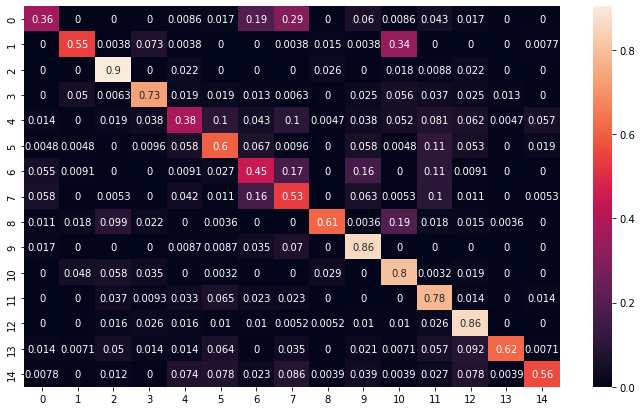

In [160]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [150]:
#So I use this model for the ensamble of networks, playing with the value of dropout 

In [161]:
models = [] 

In [162]:
models.append(new_model)

In [ ]:
#model = CNN_5(1,15,batch_norm=True,p=0.1).to(device)

In [166]:
def ensemble_of_networks(train_loader,val_loader,number=5,p=0.2): 
    models = []
    prob = p
    for i in range(number): 
        writer = SummaryWriter(f'runs/ENSAMBLE'+str(i))
        model = CNN_5(1,15,batch_norm=True,p=prob).to(device)
        model.initialize_weight() 
        criterion = nn.CrossEntropyLoss() 
        optimizer = optim.Adam(model.parameters(),lr = learning_rate)
        PATH_ENSAMBLE = "model_ensamble.py"
        _ = ep =early_stopping(PATH_ENSAMBLE,5,model,train_loader,val_loader, criterion, optimizer,writer,80,patience=15,device=device)
        model = CNN_5(1,15,batch_norm=True,p=prob)
        check = torch.load(PATH_ENSAMBLE)
        model.load_state_dict(check['parameters'])
        models.append(model)
    return models 

In [22]:
models = ensemble_of_networks(augmented_train_loader,val_loader)

In [23]:
data,targets = next(iter(val_loader))

In [162]:
def ensemble_accuracy(models,val_loader,device="cpu"): 
    for i in range(len(models)): 
        _ = models[i].eval()
    num_correct = 0
    num_samples = 0
    with torch.no_grad():
        for _,(data,targets) in enumerate(val_loader): 
            scores = []
            for i in range(len(models)): 
                s = models[i](data)
                s = s.numpy()
                scores.append(s)
            scores = np.asarray(scores) 
            means = np.mean(scores,axis = 0)
            predictions = np.argmax(means,axis=1)
            predictions=torch.from_numpy(predictions)
            num_correct += (predictions==targets).sum() 
            num_samples += predictions.size(0) 
     
    accuracy = float(num_correct)/float(num_samples)*100
    return accuracy

In [153]:
accuracy_ensamble = ensemble_accuracy(models,val_loader)

In [154]:
accuracy_ensamble

70.66666666666667

In [155]:
accuracy_ensamblep2 = accuracy_ensamble

In [157]:
test_accuracy_ensemble = ensemble_accuracy(models,test_loader)

In [158]:
test_accuracy_ensemble


63.417085427135675

In [159]:
#I grow the value of the parameter p of fropout 

In [160]:
models2 = ensemble_of_networks(train_loader,val_loader,number=5,p=0.4)

In [167]:
accuracy_ensemble_p4 = ensemble_accuracy(models2,test_loader)

In [165]:
accuracy_ensamble_p4

42.47906197654942

In [168]:
models2 = ensemble_of_networks(train_loader,val_loader,number=5,p=0.1)

In [172]:
test_accuracy_ensemble = ensemble_accuracy(models2,test_loader)

In [173]:
test_accuracy_ensemble

54.438860971524285

In [ ]:
#accuracy_ensamble_10 = ensemble_accuracy(models,val_loader)

In [174]:
models_10 = ensemble_of_networks(train_loader,val_loader,number=10,p=0.3)

In [175]:
test_accuracy_ensemble_10_3 = ensemble_accuracy(models_10,test_loader)

In [176]:
test_accuracy_ensemble_10_3

53.768844221105525

In [177]:
models_10 = ensemble_of_networks(train_loader,val_loader,number=10,p=0.2)

In [178]:
test_accuracy_ensemble_10_2 = ensemble_accuracy(models_10,test_loader)

In [181]:
test_accuracy_ensemble_10_2

55.812395309882746